In [ ]:
!pip install PySastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 2.4 MB/s eta 0:00:00


In [ ]:
from tqdm.notebook import tqdm
import time
import tensorflow as tf
import numpy as np
import pandas as pd

## Load the data

In [ ]:
data = pd.read_csv('/content/data.csv', encoding='latin-1')

alay_dict = pd.read_csv('/content/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original',
                                      1: 'replacement'})

id_stopword_dict = pd.read_csv('/content/stopwordbahasa.csv', heade## BERT - TensorFlow 2 & Hugging Face Transformers Libraryr=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

Muhammad Okky Ibrohim and Indra Budi. 2019. Multi-label Hate Speech and Abusive Language Detection in Indonesian Twitter. In ALW3: 3rd Workshop on Abusive Language Online, 46-57.


* Link paper: https://aclanthology.org/W19-3506.pdf
* Link GitHub: https://github.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection

In [ ]:
print("Shape: ", data.shape)
data.head(15)

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0
5,USER Ya bani taplak dkk \xf0\x9f\x98\x84\xf0\x...,1,1,0,1,0,0,0,0,1,0,1,0
6,deklarasi pilkada 2018 aman dan anti hoax warg...,0,0,0,0,0,0,0,0,0,0,0,0
7,Gue baru aja kelar re-watch Aldnoah Zero!!! pa...,0,1,0,0,0,0,0,0,0,0,0,0
8,Nah admin belanja satu lagi port terbaik nak m...,0,0,0,0,0,0,0,0,0,0,0,0
9,USER Enak lg klo smbil ngewe',0,1,0,0,0,0,0,0,0,0,0,0


## Cleaning Tweet Text

In [ ]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

def preprocess(text):
    text = lowercase(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 2
    text = normalize_alay(text) # 3
    text = stemming(text) # 4
    text = remove_stopword(text) # 5
    return text

In [ ]:
data['Tweet'] = data['Tweet'].apply(preprocess)

In [ ]:
data.drop(columns=['HS_Other'	,"HS_Weak"	,'HS_Moderate',	'HS_Strong'],inplace=True)
print("Shape: ", data.shape)
data.head(15)

Shape:  (13169, 9)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender
0,cowok usaha lacak perhati gue lantas remeh per...,1,1,1,0,0,0,0,0
1,telat tau edan sarap gue gaul cigax jifla cal ...,0,1,0,0,0,0,0,0
2,41 kadang pikir percaya tuhan jatuh kali kali ...,0,0,0,0,0,0,0,0
3,ku tau mata sipit lihat,0,0,0,0,0,0,0,0
4,kaum cebong kafir lihat dongok dungu haha,1,1,0,1,1,0,0,0
5,ya bani taplak kawan kawan xf0 x9f x98 x84 xf0...,1,1,0,1,0,0,0,0
6,deklarasi pilih kepala daerah 2018 aman anti h...,0,0,0,0,0,0,0,0
7,gue selesai re watch aldnoah zero kampret 2 ka...,0,1,0,0,0,0,0,0
8,admin belanja po nak makan ais kepal milo ais ...,0,0,0,0,0,0,0,0
9,enak ngewe,0,1,0,0,0,0,0,0


## Handling data imbalance

In [ ]:
print("HS Abusive shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-HS and Abusive shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

HS Abusive shape:  (7309, 9)
Non-HS and Abusive shape:  (5860, 9)


In [ ]:
import pandas as pd
import numpy as np

# Assuming 'data' is your original DataFrame with 'Tweet' and class labels
X = data['Tweet']
y = data[['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
          'HS_Physical', 'HS_Gender']]

# Calculate the number of HS_Weakinstances to keep for each class (make toxic class equal to non-toxic class)
min_class_instances = min(y[(y['HS'] == 0) & (y['Abusive'] == 0)].shape[0], y[(y['HS'] == 1) | (y['Abusive'] == 1)].shape[0])

# Downsample the toxic class (where either 'HS' or 'Abusive' is 1) separately in-place
toxic_class_indices = y[(y['HS'] == 1) | (y['Abusive'] == 1)].index

random_seed = 42
np.random.seed(random_seed)

# Randomly drop instances from the toxic class to achieve balance
dropped_indices_toxic = np.random.choice(toxic_class_indices, size=len(toxic_class_indices) - min_class_instances, replace=False)

# Drop the instances in-place using the index of the DataFrame
data.drop(index=dropped_indices_toxic, inplace=True)

In [ ]:
print("HS and Abusive shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-HS and Abusive shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

HS and Abusive shape:  (5860, 9)
Non-HS and Abusive shape:  (5860, 9)


In [ ]:
data.reset_index(drop=True, inplace=True)

In [ ]:
data.tail(10)

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender
11710,2 buku aktivitas angry burung the film kreativ...,0,0,0,0,0,0,0,0
11711,nostalgia budaya nos tal gia rindu kadang kada...,0,0,0,0,0,0,0,0
11712,berengsek orang bikin gue kasar mulu,1,1,1,0,0,0,0,0
11713,kepala polisi daerah babi biadab bodoh otak kali,1,1,0,1,0,0,0,0
11714,orang yahudi kristen muslim be emu kumpul mala...,0,0,0,0,0,0,0,0
11715,bicara ndasmu congor sekata anjing,1,1,1,0,0,0,1,0
11716,kasur enak kunyuk,0,1,0,0,0,0,0,0
11717,hati hati bisu bosan duh xf0 x9f x98 xaa,0,0,0,0,0,0,0,0
11718,bom real mudah deteksi bom kubur dahsyat ledak...,0,0,0,0,0,0,0,0
11719,situ foto ya kutil onta,1,1,1,0,0,0,0,0


## Checking text max length

In [ ]:
#Initialize Bert tokenizer and masks
from transformers import BertTokenizer

bert_model_name = 'indobenchmark/indobert-base-p1'

tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)

max_word_len = 0

for tweet in tqdm(data['Tweet']):
    # Tokenize the tweet
    tokens = tokenizer.tokenize(tweet)

    # Update max_word_len if the current tweet has more tokens
    max_word_len = max(max_word_len, len(tokens))

print("Max Word Length in the 'Tweet' column:", max_word_len)

  0%|          | 0/11720 [00:00<?, ?it/s]

Max Word Length in the 'Tweet' column: 234


## Tokenization and Attention mask

Pre-trained link : https://huggingface.co/indobenchmark/indobert-base-p1

In [ ]:
MAX_LEN = 240

def tokenize_sentences(sentences, tokenizer, max_seq_len):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True,# Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,
                            truncation = True,
                            padding = "max_length"# Truncate all sentences.
                    )

        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

input_ids = tokenize_sentences(data['Tweet'], tokenizer, MAX_LEN)
attention_masks = create_attention_masks(input_ids)

  0%|          | 0/11720 [00:00<?, ?it/s]

## Splitting preparong data for training (val 10%)

In [ ]:
label_cols = ['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion',
       'HS_Race', 'HS_Physical', 'HS_Gender']

In [ ]:
from sklearn.model_selection import train_test_split

labels =  data[label_cols].values
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=0, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=0, test_size=0.1)

train_size = len(train_inputs)
validation_size = len(validation_inputs)

In [ ]:
print(f"train : {len(train_inputs)} and train labels : {len(train_labels)}")

train : 10548 and train labels : 10548


In [ ]:
print(f"train : {len(validation_inputs)} and train labels : {len(validation_labels)}")

train : 1172 and train labels : 1172


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
#Create train and validation datasets
BATCH_SIZE=32
NR_EPOCHS=1

def create_dataset(data_tuple, epochs, batch_size=BATCH_SIZE, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(1)

    return dataset

train_dataset = create_dataset((train_inputs, train_masks, train_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)
validation_dataset = create_dataset((validation_inputs, validation_masks, validation_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)

## 3. Training Loop

### TF Bert Classifier

In [ ]:
from transformers import TFBertModel, TFBertForSequenceClassification
from tensorflow.keras.layers import Dense, Flatten

class BertClassifier(tf.keras.Model):
        def __init__(self, bert: TFBertModel, num_classes: int):
            super().__init__()
            self.bert = bert
            self.classifier = Dense(num_classes, activation='sigmoid')

        @tf.function
        def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
            outputs = self.bert(input_ids,
                                   attention_mask=attention_mask,
                                   token_type_ids=token_type_ids,
                                   position_ids=position_ids,
                                   head_mask=head_mask)
            cls_output = outputs[1]
            cls_output = self.classifier(cls_output)

            return cls_output

model = BertClassifier(TFBertModel.from_pretrained(bert_model_name), len(label_cols))

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
import time
from transformers import create_optimizer
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle


lw = 2
steps_per_epoch = (train_size // BATCH_SIZE) * NR_EPOCHS
validation_steps = (validation_size // BATCH_SIZE) * NR_EPOCHS

# | Loss Function
loss_object = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
train_loss = tf.keras.metrics.Mean(name='train_loss')
validation_loss = tf.keras.metrics.Mean(name='test_loss')

# | Optimizer
warmup_steps = steps_per_epoch // 3
total_steps = steps_per_epoch * NR_EPOCHS - warmup_steps
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

# | Metrics
train_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]
validation_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]

@tf.function
def train_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(token_ids, attention_mask=masks)
        loss = loss_object(labels, predictions)
    #Loss Function into gradient
    gradients = tape.gradient(loss, model.trainable_variables)
    #Apply gradient to optimizer
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)

    for i, auc in enumerate(train_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])

@tf.function
def validation_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    predictions = model(token_ids, attention_mask=masks, training=False)
    v_loss = loss_object(labels, predictions)

    validation_loss(v_loss)
    for i, auc in enumerate(validation_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])

fpr = dict()
tpr = dict()
roc_auc = dict()
n_class = 8


def train(model, train_dataset, val_dataset, train_steps_per_epoch, val_steps_per_epoch, epochs):
    for epoch in range(epochs):
        print('=' * 50, f"EPOCH {epoch+1}", '=' * 50)

        start = time.time()

        for i, (token_ids, masks, labels) in enumerate(tqdm(train_dataset, total=train_steps_per_epoch)):
            train_step(model, token_ids, masks, labels)
            if i % 280 == 0:
                print(f'\nTrain Step: {i}, Loss: {train_loss.result()}')
                for i, label_name in enumerate(label_cols):
                    print(f"{label_name} roc_auc {train_auc_metrics[i].result()}")
                    train_auc_metrics[i].reset_states()

        for i, (token_ids, masks, labels) in enumerate(tqdm(val_dataset, total=val_steps_per_epoch)):
            validation_step(model, token_ids, masks, labels)

        print(f'\nEpoch {epoch+1}, Validation Loss: {validation_loss.result()}, Time: {time.time()-start}\n')

        for i, label_name in enumerate(label_cols):
            print(f"{label_name} roc_auc {validation_auc_metrics[i].result()}")
            validation_auc_metrics[i].reset_states()

        print('\n')

# Train your model
train(model, train_dataset, validation_dataset, steps_per_epoch, validation_steps, NR_EPOCHS)

================================================== EPOCH 1 ==================================================


  0%|          | 0/329 [00:00<?, ?it/s]


Train Step: 0, Loss: 0.9280071258544922
HS roc_auc 0.494140625
Abusive roc_auc 0.6666666269302368
HS_Individual roc_auc 0.6354166269302368
HS_Group roc_auc 0.2213541865348816
HS_Religion roc_auc 0.7096773982048035
HS_Race roc_auc 0.5535714626312256
HS_Physical roc_auc 0.0
HS_Gender roc_auc 0.0

Train Step: 280, Loss: 0.2231529802083969
HS roc_auc 0.8871675729751587
Abusive roc_auc 0.9449611902236938
HS_Individual roc_auc 0.837645411491394
HS_Group roc_auc 0.8613859415054321
HS_Religion roc_auc 0.9236047267913818
HS_Race roc_auc 0.9498997330665588
HS_Physical roc_auc 0.8146411776542664
HS_Gender roc_auc 0.8459104299545288


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 1, Validation Loss: 0.1810450553894043, Time: 521.2789776325226

HS roc_auc 0.9229504466056824
Abusive roc_auc 0.9691636562347412
HS_Individual roc_auc 0.8905370235443115
HS_Group roc_auc 0.9070720672607422
HS_Religion roc_auc 0.9518027901649475
HS_Race roc_auc 0.980813205242157
HS_Physical roc_auc 0.9361714124679565
HS_Gender roc_auc 0.8907312154769897




In [ ]:
model.summary()

Model: "bert_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_1 (TFBertMod  multiple                  124441344 
 el)                                                             
                                                                 
 dense_1 (Dense)             multiple                  6152      
                                                                 
Total params: 124447496 (474.73 MB)
Trainable params: 124447496 (474.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


  0%|          | 0/36 [00:00<?, ?it/s]

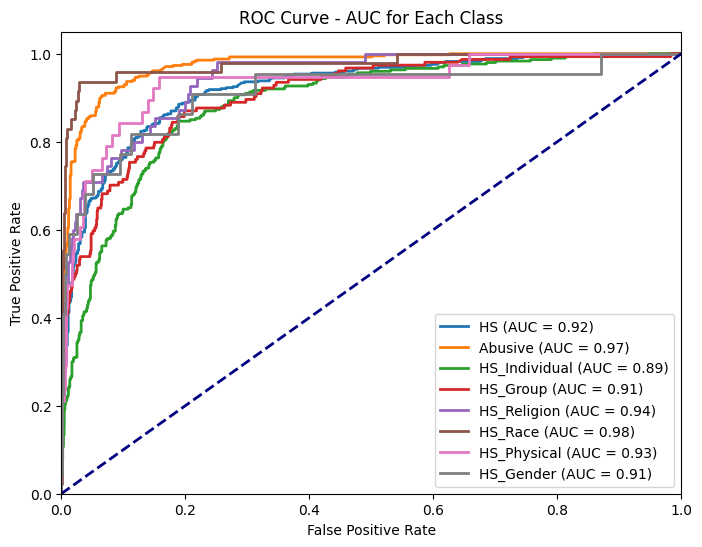

In [ ]:
def plot_roc_curve(y_true, y_score, class_names):
    plt.figure(figsize=(8, 6))

    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - AUC for Each Class')
    plt.legend(loc="lower right")
    plt.show()

def evaluate_and_plot_roc(model, validation_dataset, validation_steps, label_cols):
    y_true = []
    y_score = []

    for (token_ids, masks, labels) in tqdm(validation_dataset, total=validation_steps):
        predictions = model(token_ids, attention_mask=masks, training=False)
        y_true.extend(labels.numpy())
        y_score.extend(predictions.numpy())

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    plot_roc_curve(y_true, y_score, label_cols)

# Plotting roc_auc
evaluate_and_plot_roc(model, validation_dataset, validation_steps, label_cols)

## Testing prompt input text

In [ ]:
def analyze_text(input_text, model, tokenizer, max_seq_len=MAX_LEN):
    # Tokenize the input text
    input_ids = tokenize_sentences([input_text], tokenizer, max_seq_len)
    attention_masks = create_attention_masks(input_ids)

    # Generate output from the model
    output = model.predict([np.array(input_ids), np.array(attention_masks)])

    # Threshold for classifying as positive
    threshold = 0.5
    predicted_labels = [label_cols[i] for i, prob in enumerate(output[0]) if prob > threshold]

    return predicted_labels

# Take user input
user_input = input("Enter a sentence or word: ")

# Analyze the user input
predicted_labels = analyze_text(user_input, model, tokenizer)
print("Predicted Labels:", predicted_labels)

Enter a sentence or word: doni orangnya kaya anjing babi setan


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 68ms/step
Predicted Labels: ['HS', 'Abusive', 'HS_Individual']


## 4. Save model for later use


In [ ]:
model.save("/content/bert-classifier-fine-tuned")

In [ ]:
!zip -r /content/bert-classifier-fine-tuned.zip /content/bert-classifier-fine-tuned

  adding: content/bert-classifier-fine-tuned/ (stored 0%)
  adding: content/bert-classifier-fine-tuned/assets/ (stored 0%)
  adding: content/bert-classifier-fine-tuned/saved_model.pb (deflated 92%)
  adding: content/bert-classifier-fine-tuned/variables/ (stored 0%)
  adding: content/bert-classifier-fine-tuned/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/bert-classifier-fine-tuned/variables/variables.index (deflated 76%)
  adding: content/bert-classifier-fine-tuned/fingerprint.pb (stored 0%)
  adding: content/bert-classifier-fine-tuned/keras_metadata.pb (deflated 96%)
